In [1]:
from abc import ABC, abstractmethod
import random
import numpy as np
import copy
import matplotlib.pyplot as plt
from scipy.stats import poisson

In [2]:
class DiscreteEnvironment(ABC):
    
    @abstractmethod
    def step(self,action):
        pass
    
    @abstractmethod
    def reset(self):
        pass
    
class DiscreteAgent(ABC):
    @abstractmethod
    def __init__(self,env):
        pass
    
    @abstractmethod
    def update(self):
        pass
    
    @abstractmethod
    def get_action(self,state):
        pass

In [3]:
class GridWorld(DiscreteEnvironment):
    def __init__(self,r,c):
        self.maxrow = r
        self.maxcol = c
        self.tot_act = 4
        self.actions = [0,1,2,3]
        self.vi_list = []
        self.pi_list = []
        self.reset()  
        
    def foul_state(self,row,col):
        if row < 0 or row >= self.maxrow or col < 0 or col >= self.maxcol:
            return 1
        return 0
    
    def step(self,action):
        row_copy = self.navigate_row
        col_copy = self.navigate_col
        
        if self.navigate_row == self.goal_row and self.navigate_col == self.goal_col:
            reward = 10
            done = True
            state = (self.navigate_row,self.navigate_col)
        else:
            if action == 0:
                self.navigate_row -= 1
            elif action == 1:
                self.navigate_row += 1
            elif action == 2:
                self.navigate_col -= 1
            elif action == 3:
                self.navigate_col += 1

            if self.foul_state(self.navigate_row,self.navigate_col): 
                reward = -1
                done = True
                state = (row_copy,col_copy)
                #print(state)
            elif self.navigate_row == self.goal_row and self.navigate_col == self.goal_col:
                reward = 10
                done = True
                state = (self.navigate_row,self.navigate_col)
            else: 
                reward = 0
                done = False
                state = (self.navigate_row,self.navigate_col)
        
        return state,reward,done
    
    '''
    Used for dynamic programming methods where the start state is selected iteratively
    '''
    def set_start_state(self,state):
        self.navigate_row = state[0]
        self.navigate_col = state[1]
        
    '''
    Initialize random start and goal state
    '''
    def reset(self):
        
        #self.start_row = 0#random.randint(0,self.maxrow-1)
        #self.start_col = 0#random.randint(0,self.maxcol-1)
        self.goal_row = 7#random.randint(0,self.maxrow-1)
        self.goal_col = 7#random.randint(0,self.maxcol-1)
        #self.navigate_row = self.start_row
        #self.navigate_col = self.start_col 
    
    '''
    Under construction
    '''
    def vi_test(self,Q):
        N = 10
        return_val = 0
        while N:
            start_row = 0#random.randint(0,self.maxrow-1)
            start_col = 0#random.randint(0,self.maxcol-1)
            tot_iter = 20
            while tot_iter:
                state = (start_row,start_col)
                self.set_start_state(state)
                action = np.argmax(Q[state])
                new_state,reward,done = self.step(action)
                return_val += (reward + 0.9 * np.max(Q[new_state]))/N
                if new_state[0] == self.goal_row and new_state[1] == self.goal_col:
                    break
                tot_iter -= 1
                start_row = new_state[0]
                state_col = new_state[1]
            N-=1
        self.vi_list.append(return_val)
    
    def pi_test(self,P,V):
        N = 10
        return_val = 0
        while N:
            start_row = 0#random.randint(0,self.maxrow-1)
            start_col = 0#random.randint(0,self.maxcol-1)
            tot_iter = 20
            while tot_iter:
                state = (start_row,start_col)
                self.set_start_state(state)
                action = P[state]
                new_state,reward,done = self.step(action)
                return_val += (reward + 0.9 * V[new_state])/N
                if new_state[0] == self.goal_row and new_state[1] == self.goal_col:
                    break
                tot_iter -= 1
                start_row = new_state[0]
                state_col = new_state[1]
            N-=1
        self.pi_list.append(return_val)

In [4]:
class ValueIteration(DiscreteAgent):
    def __init__(self,env):
        self.env = env
        self.gamma = 0.9
        self.Q = np.zeros((env.maxrow,env.maxcol,env.tot_act))
        self.V = np.zeros((env.maxrow,env.maxcol))
        
    def update(self):
        for row in range(len(self.V)):
            for col in range(len(self.V[row])):
                state=(row,col)
                for action in self.env.actions:
                    self.env.set_start_state(state)
                    new_state,reward,done = self.env.step(action)
                    #print(reward)
                    self.Q[state][action] = reward + self.gamma * self.V[new_state]
                self.V[state] = np.max(self.Q[state])
        
        #print(self.V)
        self.env.vi_test(self.Q)
    
    def get_action(self):
        pass

In [15]:
class PolicyIteration(DiscreteAgent):
    def __init__(self,env):
        self.env = env
        self.gamma = 0.9
        self.Q = np.zeros((env.maxrow,env.maxcol,env.tot_act))
        self.V = np.zeros((env.maxrow,env.maxcol))
        self.policy = np.random.randint(env.tot_act,size=(env.maxrow,env.maxcol))
        self.policy_stable = False
    
    def update(self):
        while not self.policy_stable:
            self.policy_evaluation()
            self.policy_improvement()
    
    def policy_evaluation(self):
        eps = 1e-2
        while True:
            delta = 0
            for row in range(len(self.V)):
                for col in range(len(self.V[row])):
                    state=(row,col)
                    v = self.V[state]
                    self.env.set_start_state(state)
                    action = self.policy[state]
                    new_state,reward,done = self.env.step(action)
                    self.Q[state][action] = reward + \
                                            self.gamma * self.V[new_state]
                    self.V[state] = self.Q[state][action]
                    delta = max(delta,np.abs(v-self.V[state]))
            #self.env.pi_test(self.policy,self.V)       
            #print(self.V)
            if delta < eps:
                break
            
    def policy_improvement(self):
        self.policy_stable = True
        for row in range(len(self.V)):
            for col in range(len(self.V[row])):
                state=(row,col)
                v = self.V[state]
                for action in self.env.actions:
                    self.env.set_start_state(state)
                    new_state,reward,done = self.env.step(action)
                    self.Q[state][action] = reward + self.gamma * self.V[new_state]
                #if v != np.max(self.Q[state]):
                self.V[state] = np.max(self.Q[state])
                
                if np.argmax(self.Q[state]) != self.policy[state]:
                    self.policy[state] = np.argmax(self.Q[state])
                    self.policy_stable = False
        #print(self.V)
        self.env.pi_test(self.policy,self.V)
                    
    
    def get_action(self):
        pass

## Value Iteration

In [16]:
env = GridWorld(8,8)
agent  = ValueIteration(env)


sweep_no,max_sweeps = 0,50
while sweep_no < max_sweeps:
    #print('new_update')
    agent.update()
    sweep_no+=1

In [17]:
agent.V

array([[24.90328076, 27.72757613, 30.86568209, 34.35246649, 38.22667138,
        42.53134348, 47.31431248, 52.62872248],
       [27.72757613, 30.86568209, 34.35246649, 38.22667138, 42.53134348,
        47.31431248, 52.62872248, 58.53362248],
       [30.86568209, 34.35246649, 38.22667138, 42.53134348, 47.31431248,
        52.62872248, 58.53362248, 65.09462248],
       [34.35246649, 38.22667138, 42.53134348, 47.31431248, 52.62872248,
        58.53362248, 65.09462248, 72.38462248],
       [38.22667138, 42.53134348, 47.31431248, 52.62872248, 58.53362248,
        65.09462248, 72.38462248, 80.48462248],
       [42.53134348, 47.31431248, 52.62872248, 58.53362248, 65.09462248,
        72.38462248, 80.48462248, 89.48462248],
       [47.31431248, 52.62872248, 58.53362248, 65.09462248, 72.38462248,
        80.48462248, 89.48462248, 99.48462248],
       [52.62872248, 58.53362248, 65.09462248, 72.38462248, 80.48462248,
        89.48462248, 99.48462248, 99.48462248]])

## Poilcy Iteration

In [20]:
env1 = GridWorld(8,8)
agent  = PolicyIteration(env1)
agent.update()

In [19]:
print(agent.policy)
print(agent.V)

[[1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [3 3 3 3 3 3 3 0]]
[[25.41310495 28.23740032 31.37550628 34.86229068 38.73649557 43.04116767
  47.82413667 53.13854667]
 [28.23740032 31.37550628 34.86229068 38.73649557 43.04116767 47.82413667
  53.13854667 59.04344667]
 [31.37550628 34.86229068 38.73649557 43.04116767 47.82413667 53.13854667
  59.04344667 65.60444667]
 [34.86229068 38.73649557 43.04116767 47.82413667 53.13854667 59.04344667
  65.60444667 72.89444667]
 [38.73649557 43.04116767 47.82413667 53.13854667 59.04344667 65.60444667
  72.89444667 80.99444667]
 [43.04116767 47.82413667 53.13854667 59.04344667 65.60444667 72.89444667
  80.99444667 89.99444667]
 [47.82413667 53.13854667 59.04344667 65.60444667 72.89444667 80.99444667
  89.99444667 99.99444667]
 [53.13854667 59.04344667 65.60444667 72.89444667 80.99444667 89.99444667
  99.99444667 99.99444667]]


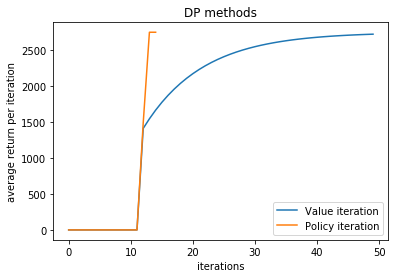

In [21]:
iteration_vi = list(range(0,max_sweeps))
iteration_pi = list(range(0,len(env1.pi_list)))
plt.plot(iteration_vi,env.vi_list,label='Value iteration')
plt.plot(iteration_pi,env1.pi_list,label = 'Policy iteration')
plt.xlabel("iterations")
plt.ylabel("average return per iteration")
plt.title("DP methods")
plt.legend()
plt.show()

In [22]:
env1.pi_list

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1488.7160839835265,
 2754.1712594227324,
 2754.2163181756237]

## Car Rental

In [35]:
class CarRental:
    def __init__(self,max_car_A,max_car_B):
        self.tot_act = 11
        self.maxrow = max_car_A+1
        self.maxcol = max_car_B+1
        self.car_A = max_car_A
        self.car_B = max_car_B
        self.actions = [-5,-4,-3,-2,-1,0,1,2,3,4,5]
        self.index_act = {-5:10,-4:9,-3:8,-2:7,-1:6,0:0,1:1,2:2,3:3,4:4,5:5}
        #self.gamma = 0.9
        #self.sell_reward = 10
        #self.transfer_cost = 2
        self.pi_list = []
        self.P_rental,self.P_return = self.prepare_transition()
    
    def prepare_transition(self):
        P_rental = np.zeros((self.maxrow,self.maxcol))
        P_return = np.zeros((self.maxrow,self.maxcol))
        for i in range(0,self.maxrow): #request
            for j in range(0,self.maxrow): #return
                P_rental[i][j] = self.req_ret(3,i) * self.req_ret(4,j)
                P_return[i][j] = self.req_ret(3,i) * self.req_ret(2,j)
        return P_rental,P_return
            
                
    def req_ret(self,lamb,N):
        return poisson.pmf(N, lamb)
    
    def pi_test(self,P,V):
        N = 10
        return_val = 0
        while N:
            start_row = 0#random.randint(0,self.maxrow-1)
            start_col = 0#random.randint(0,self.maxcol-1)
            tot_iter = 20
            while tot_iter:
                state = (start_row,start_col)
                self.set_start_state(state)
                action = P[state]
                new_state,reward,done = self.step(action)
                return_val += (reward + 0.9 * V[new_state])/N
                if new_state[0] == self.goal_row and new_state[1] == self.goal_col:
                    break
                tot_iter -= 1
                start_row = new_state[0]
                state_col = new_state[1]
            N-=1
        self.pi_list.append(return_val)

In [36]:
class PolicyIteration:
    def __init__(self,env):
        self.env = env
        self.gamma = 0.9
        self.Q = np.zeros((env.maxrow,env.maxcol,env.tot_act))
        self.V = np.zeros((env.maxrow,env.maxcol))
        #self.policy = np.random.randint(-5,6,size=(env.maxrow,env.maxcol))
        self.policy = np.zeros((env.maxrow,env.maxcol))
        self.policy_stable = False
    
    def update(self):
        while not self.policy_stable:
            self.policy_evaluation()
            self.policy_improvement()
    
    def policy_evaluation(self):
        print("Evaluation")
        eps = 1e-2
        #iterations = 20
        #while iterations:
        while True:
            delta = 0
            for row in range(1,len(self.V)):
                for col in range(1,len(self.V[row])):
                    state=(row,col)
                    v = self.V[state]
                    #env.set_start_state(state)
                    action = int(self.policy[state])
                    self.Q[state][action] = self.calculate_return(action,state)
                    self.V[state] = self.Q[state][action]
                    delta = max(delta,np.abs(v-self.V[state]))
            #self.env.pi_test(self.policy,self.V)       
            #print(self.V)
            #iterations-=1
            if delta < eps:
                break
            
    def calculate_return(self,action,present_state):
        action_cost = 2 * abs(action)
        total_return = 0
        for rental_A in range(len(self.env.P_rental)):
            for rental_B in range(len(self.env.P_rental[rental_A])):
                rental_state=(rental_A,rental_B)
                prob_rental = self.env.P_rental[rental_state]
                rental_cost = (rental_A + rental_B)*10
                
                for return_A in range(len(self.env.P_return)):
                    new_state_A = present_state[0] - rental_A + return_A - action
                    if new_state_A > self.env.car_A:
                        break
                        
                    elif new_state_A > 0:
                        for return_B in range(len(self.env.P_return[return_A])):
                            return_state = (return_A,return_B)
                            prob_return = self.env.P_return[return_state]

                            new_state_B = present_state[1] - rental_B + return_B + action

                            #print((new_state_A,new_state_B))

                            if new_state_B > self.env.car_B:
                                break
                            elif new_state_B > 0:
                                total_return+= prob_rental * prob_return * (rental_cost + \
                                               self.gamma * self.V[(new_state_A,new_state_B)]) 
        
        return (total_return - action_cost)
                 
                
    def policy_improvement(self):
        print("Improvement")
        self.policy_stable = True
        for row in range(1,len(self.V)):
            for col in range(1,len(self.V[row])):
                state=(row,col)
                v = self.V[state]
                for action in self.env.actions:
                    self.Q[state][action] = self.calculate_return(action,state)
                #if v != np.max(self.Q[state]):
                self.V[state] = np.max(self.Q[state])
                
                if np.argmax(self.Q[state]) != self.policy[state]:
                    self.policy[state] = np.argmax(self.Q[state])
                    self.policy_stable = False
        #print(self.V)
        #self.env.pi_test(self.policy,self.V)
                    
    
    def get_action(self):
        pass

In [37]:
env_rental = CarRental(20,20)
agent  = PolicyIteration(env_rental)
agent.update()

Evaluation


KeyboardInterrupt: 

In [30]:
agent.V

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        ,  11.26894014,  18.89262945,  27.66468138,
         36.47330873,  49.07640636,  61.91626335,  75.10031953,
         89.29826362, 101.67903315, 114.59433459, 127.71016354,
        135.5090925 , 135.37295113, 127.95007766, 115.38858088,
        100.9917978 ,  88.00044949,  78.34361652,  72.23997145,
         68.71321172],
       [  0.        ,  17.56254032,  27.1395221 ,  39.8562822 ,
         52.73756273,  64.6754949 ,  79.37128427,  93.49543631,
        105.7472972 , 119.33728798, 131.29646487, 142.17382483,
        152.38946732, 154.33143345, 148.07862945, 135.31612619,
        119.34032638, 103.88788155,  91.5882578 ,  83.1911

In [31]:
agent.policy

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., 10., 10.,  9.,  9.,  8.,  7.,  7.,  6.,  6.,
         6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.],
       [ 0.,  1.,  1.,  0.,  0., 10., 10.,  9.,  9.,  8.,  7.,  6.,  6.,
         6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.],
       [ 0.,  2.,  1.,  1.,  0.,  0., 10., 10.,  9.,  8.,  7.,  7.,  6.,
         6.,  6.,  6.,  6.,  6.,  6.,  6., 10.],
       [ 0.,  2.,  2.,  1.,  1.,  0.,  0., 10., 10.,  9.,  8.,  7.,  6.,
         6.,  6.,  6.,  6.,  6.,  6.,  6., 10.],
       [ 0.,  3.,  2.,  2.,  1.,  1.,  0.,  0., 10.,  9.,  8.,  7.,  6.,
         6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.],
       [ 0.,  3.,  3.,  2.,  2.,  1.,  1.,  0.,  0.,  9.,  8.,  7.,  6.,
         6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.],
       [ 0.,  4.,  3.,  3.,  2.,  2.,  1.,  0.,  0., 10.,  9.,  8.,  7.,
         6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.],
       [ 0.,  4.,  4.,  

## Gambling

In [ ]:
class Gamble:
    def __init__(self):
        pass